In [1]:
pwd

'C:\\Users\\Hammer\\Workspaces\\EndtoEnd'

In [2]:
#import MNIST dataset from sklearn
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist['data'],mnist['target']
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
#Display one digit from dataset
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28) #reshaping to 28*28 array

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

<Figure size 640x480 with 1 Axes>

In [6]:
#looks like 5, lets check the label:
y[0]

'5'

In [7]:
#Label here is a string. Lets convert it to number
import numpy as np
y = y.astype(np.uint8)

In [8]:
#Seperating train and test dataset
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
#Classifying the number '5'
y_train_5 = (y_train == 5) #True for all 5s, and false for other digits
y_test_5 = (y_test == 5)

In [10]:
#Stochastic Gradient Descent :  SGD Classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
#SGD depends on randomness. If we want reproducible results, you should not set
#the random_state parameter
sgd_clf.predict([some_digit])


array([ True])

In [11]:
#Implementing Cross Validation - from scratch (cross_val_score working!)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [12]:
#Validating above prediction sucess with cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
#Although the accuracy is 93%, the important point is that the dataset has
# only 10% of the images as '5'. So 90% of the time we can guess if a number is
# not '5'. This demostrates why accuracy is not a prefered measure when dealing
# with "SKEWED" datasets (when some classes are more frequest than others)

#CONFUSION MATRIX

from sklearn.model_selection import cross_val_predict
#performs K folds cross-validation, but returns predictions made of each test folds
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

<img src="images/confusion.png">

In [14]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [15]:
#Precision and metrics
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [16]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [17]:
#F score - harmonic mean of precision and recall
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

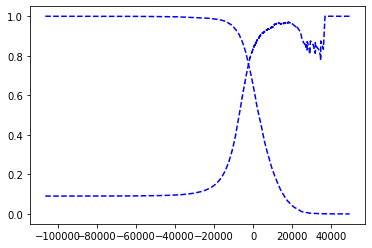

In [18]:
#From Precision/Recall Tradeoff
from sklearn.metrics import precision_recall_curve

precisions, recalls, threshold = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(predictions, recalls, threshold):
    plt.plot(threshold, precisions[:-1], "b--", label="Precision")
    plt.plot(threshold, recalls[:-1], "b--", label="Recall")


plot_precision_recall_vs_threshold(precisions, recalls, threshold)
plt.show()
    


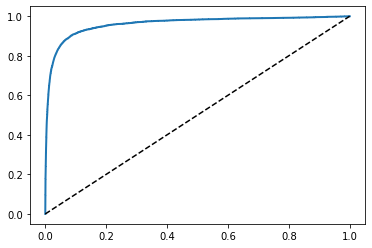

In [19]:

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--') #dashed diagonal
    
plot_roc_curve(fpr, tpr)
plt.show()


In [20]:
threshold_90_precison = thresholds[np.argmax(precisions >= 0.90)]

IndexError: index 57075 is out of bounds for axis 0 with size 3908

C:\Users\Hammer\Anaconda3\envs\condaenv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Hammer\Anaconda3\envs\condaenv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Hammer\Anaconda3\envs\condaenv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


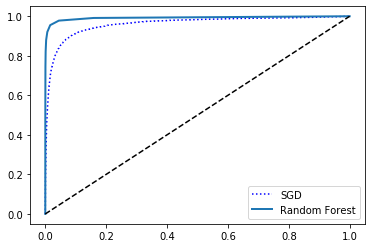

In [21]:
#ROC curve of RndomForestClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [22]:
#Another way would be to measure the AOC (area under the curve). The perfect
# classifier will have a ROC AUC = 1

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [ ]:
#Rule of Thumb: We should consider PR curve over ROC whenver Positive class
#is rare or when we care more about the false positives than the false 
# negatives, and the ROC curve otherwise

In [23]:
#Multiclass Classification
#With original dataset
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [25]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [26]:
np.argmax(some_digit_scores)

3

In [27]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [28]:
sgd_clf.classes_[5]

5

In [29]:
#OneVsOneClassifier vs OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [30]:
#Train Random Forest
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

C:\Users\Hammer\Anaconda3\envs\condaenv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=uint8)

In [31]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [33]:
#Accuracy of SGDClassfifier
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy",n_jobs=-1)

array([0.87082583, 0.87089354, 0.88628294])

In [34]:
#Standardizing the input
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_Scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_Scaled, y_train, cv=3, scoring="accuracy",n_jobs=-1)

array([0.89957009, 0.89344467, 0.89963495])

In [36]:
y_train_pred = cross_val_predict(sgd_clf, X_train_Scaled, y_train, cv=3,n_jobs=12)
conf_mat = confusion_matrix(y_train, y_train_pred)
conf_mat

array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]],
      dtype=int64)

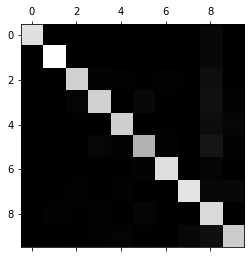

In [37]:
plt.matshow(conf_mat, cmap=plt.cm.gray)
plt.show()

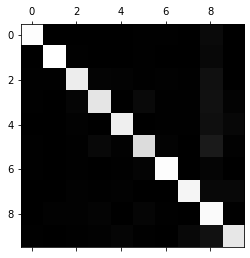

In [38]:
#For plotting errors, we first divide each value in conf_mat with images represented by the classes, so we can compare error
#rates instead of absolute errors
rows_sum = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mat / rows_sum
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

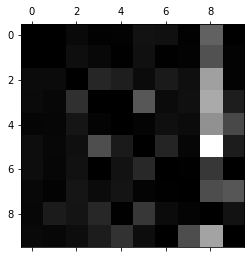

In [39]:
#Now we fill diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()


In [40]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

In [41]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

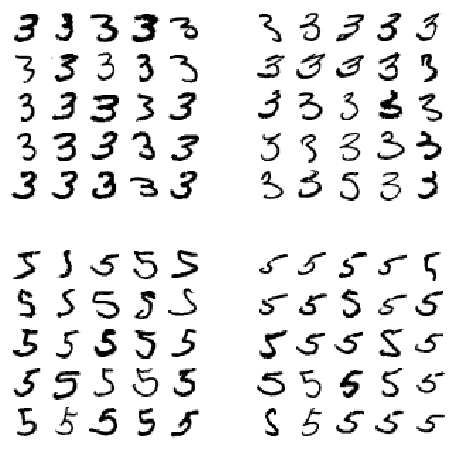

In [42]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [45]:
#KNeighboursClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

print(y_multilabel)

[[False  True]
 [False False]
 [False False]
 ...
 [False  True]
 [False False]
 [ True False]]


In [46]:
knn_clf = KNeighborsClassifier(n_jobs=12)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=12, n_neighbors=5, p=2,
                     weights='uniform')

In [47]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [48]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3,n_jobs=12)
f1_score(y_multilabel, y_train_knn_pred, average="macro" )

0.976410265560605

In [50]:
#MultiOutput Classification
#Lets develp a system whch removes noise from images. Lets start by taking MNIST images and adding noises.

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [52]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_digit]])
plot_digit(clean_digit)

IndexError: arrays used as indices must be of integer (or boolean) type